<img src="https://raw.githubusercontent.com/astrolabsoftware/fink-notebook-template/main/Fink_PrimaryLogo_WEB.jpg" width=400 />

# Fink case study: Ephemerides for Solar System Science

This notebook shows how to use the <a href="https://ssp.imcce.fr/webservices/miriade/">Miriade</a> IMCCE service with Fink Solar System Object data.

Authors: Julien Peloton, Benoit Carry, Max Mahlke.

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

import seaborn as sns
sns.set_context('talk')

import time

from astropy.coordinates import SkyCoord
import astropy.units as u

In [2]:
# Define a simple ephemerides query
def miriade(ident, jd, observer='I41', rplane='1', tcoor=5):
    '''Gets asteroid ephemerides from IMCCE Miriade for a suite of JD for a single SSO
    Original function by M. Mahlke

    :ident: int, float, str - asteroid identifier
    :jd: array - dates to query
    :observer: str - IAU Obs code - default to ZTF: https://minorplanetcenter.net//iau/lists/ObsCodesF.html
    :returns: pd.DataFrame - Input dataframe with ephemerides columns appended
              False - If query failed somehow

    '''
    
    # ------
    # Miriade URL 
    url = 'https://ssp.imcce.fr/webservices/miriade/api/ephemcc.php'
    
    if rplane=='2':
        tcoor='1'
        
    # Query parameters
    params = {
        '-name': f'a:{ident}',
        '-mime': 'json',
        '-rplane': rplane,
        '-tcoor': tcoor,
        '-output': '--jd,--colors(SDSS:r,SDSS:g)',
        '-observer': observer, 
        '-tscale': 'UTC'
    }
    
    # Pass sorted list of epochs to speed up query
    files = {'epochs': ('epochs', '\n'.join(['%.6f' % epoch
                                             for epoch in jd]))}
    # Execute query
    try:
        r = requests.post(url, params=params, files=files, timeout=2000)
    except requests.exceptions.ReadTimeout:
        return False

    j = r.json()

    # Read JSON response
    try:
        ephem = pd.DataFrame.from_dict(j['data'])
    except KeyError:
        return False

    return ephem

In [3]:
def lin_fit(x, a, b):
    """ Linear function ax + b
    """
    return a*x + b

def sine_fit(x, a, b):
    """ Sinusoidal function a*sin( 2*(x-b) )
    :x: float - in degrees
    :a: float - Amplitude
    :b: float - Phase offset

    """
    return a*np.sin( 2*np.radians(x-b) )

Let's define some constants:

In [4]:
# SSO id
ssname = '8467'

# Disctionary for filters
filters = {1:'g', 2:'R', 3:'i'}

## Fink data

In [5]:
# Get data from FINK 
r = requests.post(
  'http://134.158.75.151:24000/api/v1/sso',
  json={
    'n_or_d': ssname,
    'output-format': 'json'
  }
)

# Sort by epoch - critical for ephemerides speed up
sso = pd.read_json(r.content)
sso = sso.sort_values(by='i:jd').reset_index(drop=True)

In [6]:
# Select only a few columns
cols = [
    'd:cdsxmatch', 'd:knscore', 'd:mulens_class_1', 'd:mulens_class_2',
    'd:rfscore', 'd:roid', 'd:snn_sn_vs_all', 'd:snn_snia_vs_nonia',
    'd:tracklet', 'i:jd', 'i:ra', 'i:dec', 'i:fid', 'i:magpsf', 'i:sigmapsf',
    'i:magnr', 'i:sigmagnr', 'i:isdiffpos', 'i:magzpsci'
]

fink = sso[cols]

## Ephemerides

In [7]:
# Query ephemerides
start_t = time.time()
eph = miriade(ssname, fink['i:jd'], observer='I41' )
end_t = time.time()
print(f"This took {end_t - start_t:.3} seconds.")

sc = SkyCoord(eph['RA'], eph['DEC'], unit=(u.deg, u.deg) )

eph = eph.drop(columns=['RA','DEC'])
eph['RA'] = sc.ra.value*15
eph['Dec'] = sc.dec.value

# Add Ecliptic coordinates
eph_ec = miriade(ssname, fink['i:jd'], rplane='2' )

sc = SkyCoord(eph_ec['Longitude'], eph_ec['Latitude'], unit=(u.deg, u.deg) )
eph['Longitude'] = sc.ra.value
eph['Latitude'] = sc.dec.value


# Merge fink & Eph
info = pd.concat( [eph, fink], axis=1 )

# Compute magnitude reduced to unit distance
info['i:magpsf_red'] = info['i:magpsf'] - 5*np.log10( info['Dobs']*info['Dhelio'] )

This took 1.72 seconds.


## Magnitude comparison

[-0.06871663 11.81497541] [ 0.03682156 28.16604001]
[-0.07477478 -6.97139835] [0.03886444 7.11513458]


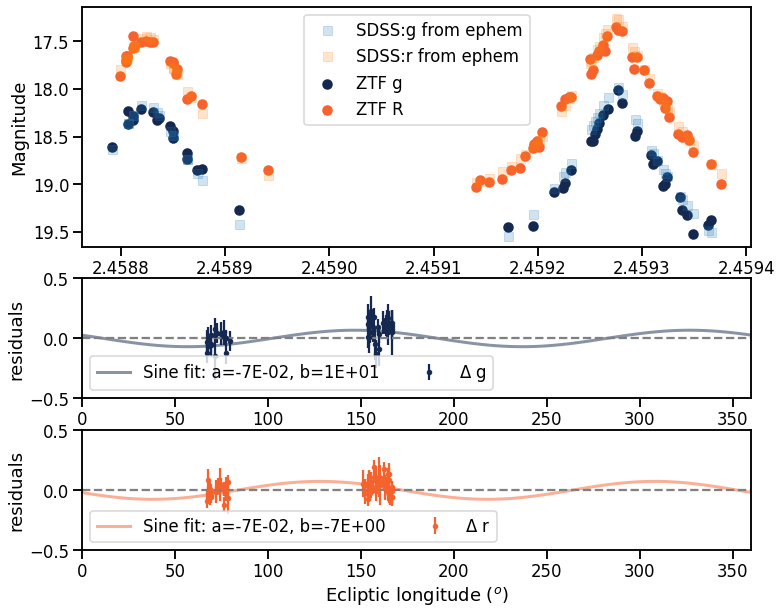

In [8]:
# Simple plot
filts = sso['i:fid'].unique()

fig, ax = plt.subplots(
    3, 1, 
    figsize=(12, 10), 
#     sharex=True, 
    gridspec_kw={'height_ratios': [3, 1.5, 1.5]}
)

colors = ['#15284F', '#F5622E']
for i,f in enumerate(filts):
    cond = sso['i:fid']==f
    
    ax[0].scatter(
        sso.loc[cond,'i:jd'], 
        sso.loc[cond,'i:magpsf'], 
        label='ZTF {:}'.format(filters[f]),
        color=colors[i],
        alpha=1.0
    )

    ax[0].plot(
        eph.Date[cond], 
        eph['SDSS:{}'.format(filters[f].lower())][cond], 
        ls='', 
        marker='s', 
        label='SDSS:{} from ephem'.format(filters[f].lower()), alpha=0.2)

ax[0].set_ylim(ax[0].get_ylim()[::-1])
ax[0].legend(loc='best')
ax[0].set_ylabel('Magnitude')
ax[0].set_xlabel('Epoch (JD)');

for i,f in enumerate(filts):
    cond = sso['i:fid']==f
    
    # Magnitude
    mag = sso.loc[cond,'i:magpsf'][cond]
    err= sso.loc[cond,'i:sigmapsf'][cond]
    
    ephemData = eph['SDSS:{}'.format(filters[f].lower())][cond]

    diff = mag - ephemData
    
    popt, pcov = curve_fit(sine_fit, eph.Longitude[cond], diff)
    perr = np.sqrt(np.diag(pcov))
    print(popt, perr)
    
    ax[i+1].errorbar(
        eph.Longitude[cond], 
        diff, 
        yerr=err, 
        ls='', marker='.', label=r'$\Delta$ {}'.format(filters[f].lower()), color=colors[i])
    
    longitude_arr = np.linspace(0,360,num=100)
    ax[i+1].plot(
        longitude_arr, 
        sine_fit(longitude_arr, *popt),
        label='Sine fit: a={:.0E}, b={:.0E}'.format(*popt),
        color=colors[i],
        ls='-',
        alpha=0.5,
        lw=3
    )
    
    ax[i+1].legend(loc='best', ncol=2)

    ax[i+1].set_ylim(-0.5, 0.5)
    ax[i+1].set_xlim(0,360)
    ax[i+1].axhline(0, ls='--', color='grey')
    ax[i+1].set_ylabel('residuals')
ax[2].set_xlabel('Ecliptic longitude ($^o$)');

The residuals between observed and predicted magnitude are most-likely due to the difference of aspect angle: the objets is not a perfect sphere. We are seeing its oblateness here.

## Position comparison

Text(0, 0.5, '$\\Delta$DEC ($^{\\prime\\prime}$)')

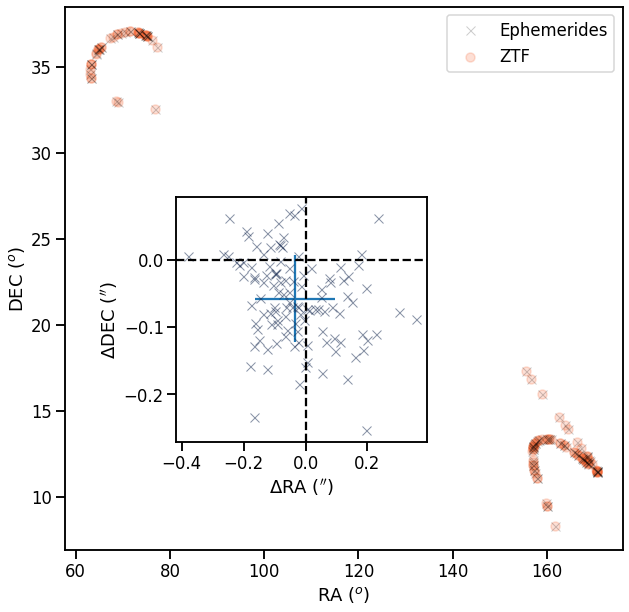

In [9]:
fig, ax = plt.subplots(
    figsize=(10, 10), 
    sharex=True,
)

ax.scatter(sso['i:ra'], sso['i:dec'], label='ZTF', alpha=0.2, color=colors[1])
    
ax.plot(eph.RA, eph.Dec, ls='', color='black', marker='x', alpha=0.2, label='Ephemerides')
ax.legend(loc='best')
ax.set_xlabel('RA ($^o$)')
ax.set_ylabel('DEC ($^o$)')

axins = ax.inset_axes([0.2, 0.2, 0.45, 0.45])

deltaRAcosDEC = (sso['i:ra'] - eph.RA)*np.cos(np.radians(sso['i:dec']))*3600
deltaDEC = (sso['i:dec']- eph.Dec)*3600
axins.plot( deltaRAcosDEC, deltaDEC, ls='', color=colors[0], marker='x', alpha=0.5)
axins.errorbar( np.mean(deltaRAcosDEC), np.mean(deltaDEC), xerr=np.std(deltaRAcosDEC), yerr=np.std(deltaDEC) )
axins.axhline(0, ls='--', color='black')
axins.axvline(0, ls='--', color='black')
axins.set_xlabel(r'$\Delta$RA ($^{\prime\prime}$)')
axins.set_ylabel(r'$\Delta$DEC ($^{\prime\prime}$)')

## Phase curve

In [10]:
# SSO Color index
# BCa: I will prepare LSST/ZTF colors to have them at hand
V_minus_g = -0.32
V_minus_r = 0.13
print(V_minus_g, V_minus_r)

-0.32 0.13


In [11]:
def phi1(alpha):
    """ simple form only
    """
    return 1 - 6 * alpha / np.pi

def phi2(alpha):
    """ simple form only
    """
    return 1 - 9 * alpha / (5 * np.pi)

def phi3(alpha):
    """ simple form only
    """
    return 1 - np.exp(-4 * np.pi * np.tan(alpha / 2)**(2./3))

def V(alpha, H, G1, G2):
    """ Only phase part
    """
    return H - 2.5 * np.log10(G1 * phi1(alpha) + G2 * phi2(alpha) + (1 - G1 - G2) * phi3(alpha))

[13.94778656  0.02529728  1.70229578] [0.09131112 0.28923358 0.65900832]
[13.54648893  0.38536677  0.90031934] [0.04053947 0.1118921  0.25530751]


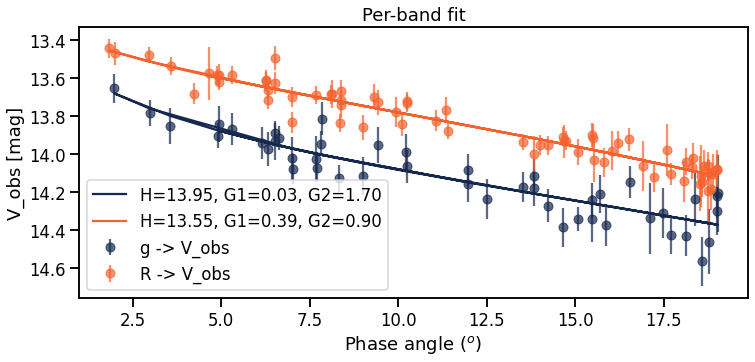

In [12]:
fig, ax = plt.subplots(figsize=(12, 5))

for i,f in enumerate(filts):
    cond = info['i:fid']==f
    
    # Color conversion
    if filters[f]=='g':
        color_sso = V_minus_g
    else:
        color_sso = V_minus_r

    popt, pcov = curve_fit(V, np.deg2rad(info.loc[cond,'Phase']), info.loc[cond,'i:magpsf_red'] + color_sso)
    perr = np.sqrt(np.diag(pcov))
    print(popt, perr)
    
    ax.errorbar(
        info.loc[cond,'Phase'], 
        info.loc[cond,'i:magpsf_red'] + color_sso, 
        yerr=info.loc[cond,'i:sigmapsf'], 
        label='{:} -> V_obs'.format(filters[f]), 
        linestyle='None', 
        marker='o', 
        color=colors[i], 
        alpha=0.7
    )
    
    ax.plot(
        info.loc[cond,'Phase'], 
        V(np.deg2rad(info.loc[cond,'Phase']), *popt),
        label='H={:.2f}, G1={:.2f}, G2={:.2f}'.format(*popt),
        color=colors[i]
    )
    
ax.legend(loc='best')
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlabel('Phase angle ($^o$)')
ax.set_ylabel('V_obs [mag]')
ax.set_title('Per-band fit');

[13.88790258  0.28002176  1.13716707] [0.04262391 0.12303919 0.28083813]


Text(0.5, 1.0, 'Multi-band fit')

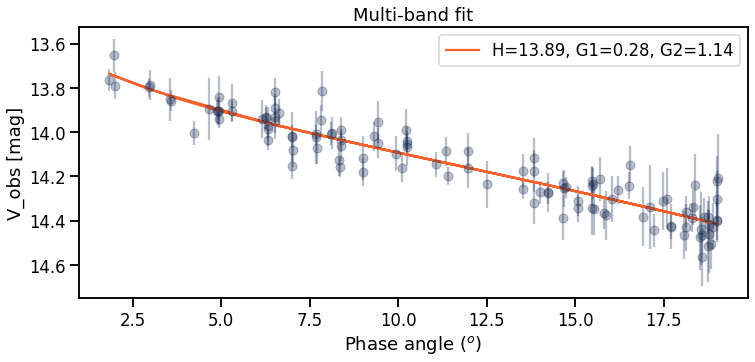

In [13]:
fig, ax = plt.subplots(figsize=(12, 5))

# Conversion
color_sso = np.ones_like(info['i:magpsf'])
for i,f in enumerate(filts):
    cond = info['i:fid']==f
    
    if filters[f]=='g':
        color_sso[cond] = V_minus_g
    else:
        color_sso[cond] = V_minus_r-V_minus_g
        
popt, pcov = curve_fit(V, np.deg2rad(info['Phase']), info['i:magpsf_red'] + color_sso)
perr = np.sqrt(np.diag(pcov))
print(popt, perr)

ax.errorbar(
    info['Phase'], 
    info['i:magpsf_red'] + color_sso, 
    yerr=info['i:sigmapsf'], 
    linestyle='None', 
    marker='o', 
    color=colors[0], 
    alpha=0.3
)

ax.plot(
    info['Phase'], 
    V(np.deg2rad(info['Phase']), *popt), 
    color=colors[1],
    label='H={:.2f}, G1={:.2f}, G2={:.2f}'.format(*popt)
)

ax.legend(loc='best')
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xlabel('Phase angle ($^o$)')
ax.set_ylabel('V_obs [mag]')
ax.set_title('Multi-band fit')